<font size=7 color ="#5499C7" >Audio MNIST</font>
- <font size=5>__Done By__ : Kasra Noorbakhsh</font>
- <font size=5>__UID__  : 810100230</font>
- <font size=5>__Goal__  : Digit Recognition</font>

### <p align="justify"><font size="6" color="#d62b5b">Step 1: Initialization and Overview</font></p>
<p align="justify">

<p align="justify"><font size="6" color="#A9CCE3"><b>Section 0: Setup & imports</b></font><br></p>

In [ ]:
# Standard library
import os
import csv
import random
import logging

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchsummary
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import librosa
import soundfile as sf
from glob import glob
from tqdm import tqdm  # For progress bars in data processing
from pathlib import Path  # Better path handling

# Set global seeds for reproducibility
def set_seed(seed=42):
    """Set seeds across libraries for reproducible results."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Log library versions for reproducibility
print("Library versions for reproducibility:")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Torch: {torch.__version__}")
print(f"Librosa: {librosa.__version__}")

# Paths (using Path for better handling)
DATA_DIR = Path("/kaggle/input/audio-mnist/data")
CACHE_DIR = Path("/kaggle/working/cache")
WORK_DIR = Path("/kaggle/working")

CACHE_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
TARGET_SR = 16000  # Target sample rate (original is 48kHz, downsample for efficiency)
TARGET_LEN = TARGET_SR  # 1 second of audio (pad/truncate to this)
N_MELS = 128  # Number of Mel filters
HOP_LENGTH = 512  # Hop length for STFT
N_FFT = 1024  # FFT window size
NUM_CLASSES = 10  # Digits 0-9
BATCH_SIZE = 64
NUM_EPOCHS = 15
RANDOM_SEED = 42  # Consistent with set_seed

Library versions for reproducibility:
NumPy: 1.26.4
Pandas: 2.2.3
Torch: 2.6.0+cu124
Librosa: 0.11.0
Using device: cuda


#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 1: Gather file list & quick metadata</b></font></p>

In [ ]:
# # Data metadata extraction
# from kaggle.api.kaggle_api_extended import KaggleApi  # For optional dataset download (install if needed)

# # Optional: Download dataset if not in Kaggle (for local reproducibility)
# if not DATA_DIR.exists():
#     print("Dataset not found locally. Downloading from Kaggle...")
#     try:
#         api = KaggleApi()
#         api.authenticate()  # Requires ~/.kaggle/kaggle.json with API token
#         api.dataset_download_files('sripaadsrinivasan/audio-mnist', path=str(WORK_DIR), unzip=True)
#         # Assume downloaded to /kaggle/working/data; adjust DATA_DIR
#         DATA_DIR = WORK_DIR / "data"
#         print(f"Dataset downloaded to {DATA_DIR}")
#     except Exception as e:
#         print(f"Error downloading dataset: {e}. Please download manually from https://www.kaggle.com/datasets/sripaadsrinivasan/audio-mnist")

rows = []
bad_files = []

# Iterate over speaker folders
speaker_folders = sorted(list(DATA_DIR.glob("*")))  # Sorted for reproducibility
for speaker_folder in tqdm(speaker_folders, desc="Processing speakers"):
    speaker_id = speaker_folder.name
    if not speaker_id.isdigit():
        continue  # Skip non-speaker folders
    # Iterate over WAV files
    for wav_path in speaker_folder.glob("*.wav"):
        fname = wav_path.name
        parts = fname.replace(".wav", "").split("_")
        if len(parts) < 3:
            bad_files.append(str(wav_path))
            rows.append({"path": str(wav_path), "speaker": speaker_id, "digit": None, "iter": None, "flag_bad_name": True})
            continue
        try:
            digit = int(parts[0])
            speaker_code = parts[1]
            iteration = parts[2]
            # Check if speaker_code matches speaker_id
            if speaker_code != speaker_id:
                bad_files.append(str(wav_path))
                rows.append({"path": str(wav_path), "speaker": speaker_id, "digit": digit, "iter": iteration, "flag_bad_name": True, "note": "Speaker mismatch"})
                continue
            if digit < 0 or digit > 9:
                raise ValueError("Invalid digit")
        except (ValueError, IndexError):
            bad_files.append(str(wav_path))
            rows.append({"path": str(wav_path), "speaker": speaker_id, "digit": None, "iter": None, "flag_bad_name": True})
            continue
        rows.append({"path": str(wav_path), "speaker": speaker_id, "digit": digit, "iter": iteration, "flag_bad_name": False})

df = pd.DataFrame(rows)
df['digit'] = df['digit'].astype('Int64')  # Handle None as <NA>

# Sort DF for reproducibility
df = df.sort_values(by='path').reset_index(drop=True)

# Logging
print(f"Total files: {len(df)} (Expected ~30,000 for full dataset)")
if bad_files:
    print(f"Bad files found: {len(bad_files)}. Examples: {bad_files[:5]}")
else:
    print("No bad files found.")
print(df.head())

# Save DF to cache for faster reloads
df.to_csv(CACHE_DIR / "metadata.csv", index=False)
print("Metadata saved to cache for reproducibility.")

Processing speakers: 100%|██████████| 61/61 [00:00<00:00, 77.86it/s]


Total files: 30000 (Expected ~30,000 for full dataset)
No bad files found.
                                            path speaker  digit iter  \
0   /kaggle/input/audio-mnist/data/01/0_01_0.wav      01      0    0   
1   /kaggle/input/audio-mnist/data/01/0_01_1.wav      01      0    1   
2  /kaggle/input/audio-mnist/data/01/0_01_10.wav      01      0   10   
3  /kaggle/input/audio-mnist/data/01/0_01_11.wav      01      0   11   
4  /kaggle/input/audio-mnist/data/01/0_01_12.wav      01      0   12   

   flag_bad_name  
0          False  
1          False  
2          False  
3          False  
4          False  
Metadata saved to cache for reproducibility.


#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 2: Durations and sample rate checks</b></font></p>

Running full inspection (all files)...


Inspecting files: 100%|██████████| 30000/30000 [02:46<00:00, 179.92it/s]


Sample rate(s) found: {48000}
Duration stats: mean=0.643s, median=0.632s, max=1.000s


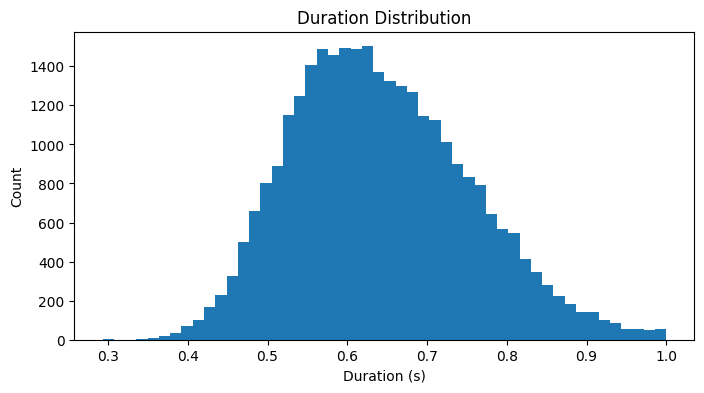

In [ ]:
# Audio file inspection: Sample rates and durations
logging.basicConfig(filename=str(CACHE_DIR / "audio_inspection.log"), level=logging.INFO)

def inspect_audio_files(df, sample_size=1000, full_check=False, random_seed=RANDOM_SEED):
    """Inspect sample rates and durations of audio files."""
    if full_check:
        paths = df['path'].tolist()
        print("Running full inspection (all files)...")
    else:
        paths = df['path'].sample(min(sample_size, len(df)), random_state=random_seed).tolist()
        print(f"Running sample inspection ({len(paths)} files)...")
    
    if not paths:
        print("No paths to inspect.")
        return
    
    durations = []
    sr_set = set()
    for p in tqdm(paths, desc="Inspecting files"):
        try:
            p = Path(p)  # Ensure Path
            info = sf.info(p)
            sr_set.add(info.samplerate)
            durations.append(info.duration)  # Use info.duration directly (frames / sr)
            # Optional: Check channels (should be 1 for mono)
            if info.channels != 1:
                logging.warning(f"Non-mono file: {p} (channels={info.channels})")
        except Exception as e:
            print(f"Failed reading {p}: {e}")
            logging.error(f"Failed reading {p}: {e}")
    
    if not durations:
        print("No valid files inspected.")
        return
    
    # Stats
    mean_dur = np.mean(durations)
    median_dur = np.median(durations)
    max_dur = np.max(durations)
    print(f"Sample rate(s) found: {sr_set}")
    if len(sr_set) > 1:
        print("Warning: Multiple sample rates detected! May need normalization.")
    print(f"Duration stats: mean={mean_dur:.3f}s, median={median_dur:.3f}s, max={max_dur:.3f}s")
    logging.info(f"SR: {sr_set}, Durations: mean={mean_dur:.3f}, median={median_dur:.3f}, max={max_dur:.3f}")
    
    # Plot histogram
    plt.figure(figsize=(8, 4))
    plt.hist(durations, bins=50)
    plt.xlabel("Duration (s)")
    plt.ylabel("Count")
    plt.title("Duration Distribution")
    plt.savefig(WORK_DIR / "duration_histogram.png")
    plt.show()
    plt.close()  # Free memory

# Run inspection (set full_check=True for all files, but it's slow)
inspect_audio_files(df, sample_size=1000, full_check=True)

### <p align="justify"><font size="6" color="#d62b5b">Step 2: Data cleaning and preprocessing</font></p>
<p align="justify">

- Convert all audio to 16 kHz mono

- Normalize and trim/pad to 1 s

- Extract log-Mel spectrograms (128 Mel bins)

- Cache features for training

#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 3: Preprocessing Functions</b></font></p>

In [4]:
def load_and_preprocess(path, target_sr=TARGET_SR, target_len=TARGET_LEN):
    """
    Load audio file, resample, normalize, trim silence, and pad/truncate to fixed length.
    
    Args:
        path (str or Path): Path to WAV file.
        target_sr (int): Target sample rate.
        target_len (int): Target length in samples.
    
    Returns:
        y (np.ndarray): Processed audio waveform (float32).
        sr (int): Sample rate (target_sr).
    
    Example:
        y, sr = load_and_preprocess('path/to/audio.wav')
    """
    try:
        path = str(path)  # Ensure string
        y, sr = librosa.load(path, sr=None, mono=True, dtype='float32')
        
        # Trim silence (top_db=30 for speech)
        y, _ = librosa.effects.trim(y, top_db=30)
        
        # Resample if needed
        if sr != target_sr:
            y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
            sr = target_sr
        
        # Normalize (max norm)
        if np.max(np.abs(y)) > 0:
            y = librosa.util.normalize(y, norm=np.inf)  # Equivalent to / max(abs(y))
        
        # Pad/truncate
        if len(y) < target_len:
            pad_width = target_len - len(y)
            y = np.pad(y, (0, pad_width), mode='constant')
        elif len(y) > target_len:
            y = y[:target_len]
        
        return y, sr
    except Exception as e:
        raise ValueError(f"Error processing {path}: {e}")

def to_logmel(y, sr, n_mels=N_MELS, hop_length=HOP_LENGTH, n_fft=N_FFT):
    """
    Convert waveform to log-Mel spectrogram.
    
    Args:
        y (np.ndarray): Audio waveform.
        sr (int): Sample rate.
        n_mels (int): Number of Mel bands.
        hop_length (int): Hop length.
        n_fft (int): FFT window size.
    
    Returns:
        logmel (np.ndarray): Log-Mel spectrogram (float32, shape (n_mels, time_frames)).
    
    Example:
        logmel = to_logmel(y, sr)  # Shape approx (128, 32) for 1s@16kHz
    """
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels,
        fmin=0, fmax=sr/2
    )
    logmel = librosa.power_to_db(mel, ref=np.max)
    return logmel.astype(np.float32)

#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 4: Quick Visual Check</b></font></p>

Sample path: /kaggle/input/audio-mnist/data/01/0_01_0.wav
Wave shape: (16000,), log-Mel shape: (128, 32)


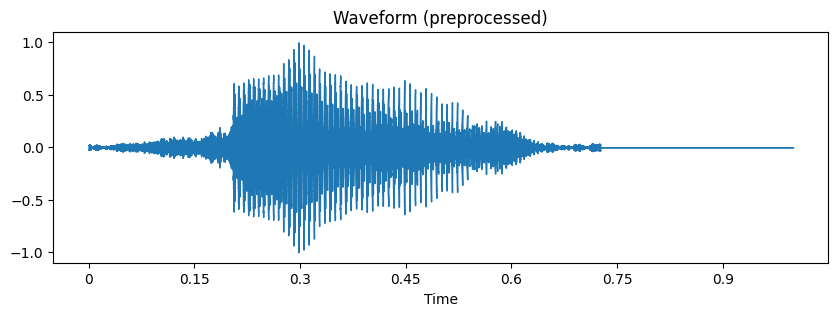

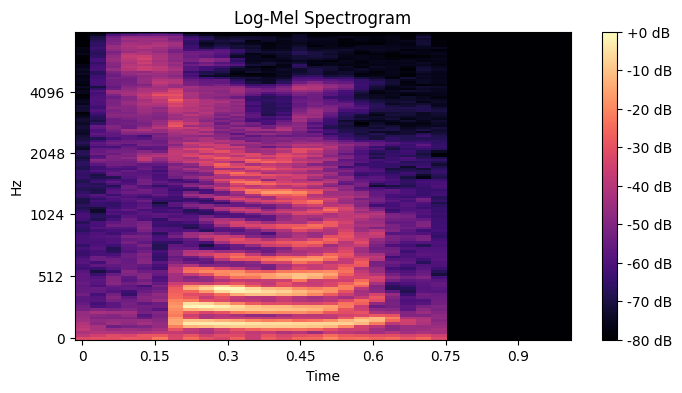

Plots saved to working dir for local export.


In [5]:
def test_preprocessing(df, fixed_sample=False, random_seed=RANDOM_SEED):
    """
    Test preprocessing on a sample file, print shapes, and plot/save visuals.
    
    Args:
        df (pd.DataFrame): Metadata DF.
        fixed_sample (bool): If True, use first good file; else random.
        random_seed (int): Seed for random choice.
    
    Example:
        test_preprocessing(df, fixed_sample=True)
    """
    # Filter to good files
    good_df = df[df['flag_bad_name'] == False]
    if good_df.empty:
        print("No good files to test.")
        return
    
    if fixed_sample:
        sample_path = good_df['path'].iloc[0]
    else:
        np.random.seed(random_seed)  # Use np for array choice
        sample_path = np.random.choice(good_df['path'].values)
    
    try:
        y, sr = load_and_preprocess(sample_path)
        logmel = to_logmel(y, sr)
        
        # Assert shapes
        expected_time_frames = (TARGET_LEN // HOP_LENGTH) + 1  # ~32
        assert y.shape == (TARGET_LEN,), f"Unexpected wave shape: {y.shape}"
        assert logmel.shape == (N_MELS, expected_time_frames), f"Unexpected log-Mel shape: {logmel.shape}"
        
        print(f"Sample path: {sample_path}")
        print(f"Wave shape: {y.shape}, log-Mel shape: {logmel.shape}")
        
        # Plot waveform
        plt.figure(figsize=(10, 3))
        librosa.display.waveshow(y, sr=sr)
        plt.title("Waveform (preprocessed)")
        plt.savefig(WORK_DIR / "sample_waveform.png")
        plt.show()
        plt.close()
        
        # Plot spectrogram
        plt.figure(figsize=(8, 4))
        librosa.display.specshow(logmel, sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
        plt.colorbar(format="%+2.0f dB")
        plt.title("Log-Mel Spectrogram")
        plt.savefig(WORK_DIR / "sample_logmel.png")
        plt.show()
        plt.close()
        
        print("Plots saved to working dir for local export.")
    except Exception as e:
        print(f"Error testing {sample_path}: {e}")

# Run test (use fixed for reproducibility, or False for random)
test_preprocessing(df, fixed_sample=True)

#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 5: Feature Extraction Loop (Preview)</b></font></p>

In [6]:
def extract_features(df, n_samples=None, cache_file=None, desc="Extracting features"):
    """
    Extract log-Mel features from a subset or full DF.
    
    Args:
        df (pd.DataFrame): Metadata DF.
        n_samples (int): Number to sample (None for all).
        cache_file (Path): Optional path to save/load .npy.
        desc (str): Progress description.
    
    Returns:
        features (np.ndarray): Stacked log-Mel arrays.
        valid_paths (list): Paths of successfully processed files.
    
    Example:
        sample_features, _ = extract_features(df, n_samples=100, cache_file=CACHE_DIR / "sample_features.npy")
    """
    # Filter good files
    good_df = df[df['flag_bad_name'] == False]
    if good_df.empty:
        raise ValueError("No good files to extract features from.")
    
    # Sample if specified
    if n_samples is not None:
        good_df = good_df.sample(min(n_samples, len(good_df)), random_state=RANDOM_SEED)
    
    paths = good_df['path'].tolist()
    
    # Optional: Load from cache
    if cache_file and cache_file.exists():
        print(f"Loading features from cache: {cache_file}")
        return np.load(cache_file), paths
    
    features = []
    valid_paths = []
    expected_shape = (N_MELS, (TARGET_LEN // HOP_LENGTH) + 1)  # (128, 32)
    
    for p in tqdm(paths, desc=desc):
        try:
            y, sr = load_and_preprocess(p)
            logmel = to_logmel(y, sr)
            assert logmel.shape == expected_shape, f"Shape mismatch for {p}: {logmel.shape} != {expected_shape}"
            features.append(logmel)
            valid_paths.append(p)
        except Exception as e:
            logging.warning(f"Failed extracting {p}: {e}")
            continue
    
    if not features:
        raise ValueError("No features extracted.")
    
    features = np.stack(features)
    print(f"Feature batch shape: {features.shape}")
    
    # Save to cache
    if cache_file:
        np.save(cache_file, features)
        print(f"Features saved to {cache_file}")
    
    return features, valid_paths

# Run on sample (for testing)
sample_features, sample_paths = extract_features(
    df, 
    n_samples=100, 
    cache_file=CACHE_DIR / "sample_features.npy",
    desc="Extracting sample features"
)

Extracting sample features: 100%|██████████| 100/100 [00:01<00:00, 99.30it/s]

Feature batch shape: (100, 128, 32)
Features saved to /kaggle/working/cache/sample_features.npy


### <p align="justify"><font size="6" color="#d62b5b">Step 3: Feature Extraction and Dataset Preparation</font></p>
<p align="justify">

- Extract and cache all log-Mel features

- Create metadata.csv

- Split dataset by speaker

- Check balance and feature shapes

#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 6: Cache Extraction (Run Once)</b></font></p>

In [7]:
# Full feature extraction and caching (per-file to avoid memory issues for 30k samples)
FEATURES_SUBDIR = CACHE_DIR / "features"
FEATURES_SUBDIR.mkdir(parents=True, exist_ok=True)

# Updated metadata path (will include feature_path)
META_PATH = CACHE_DIR / "metadata_with_features.csv"

def extract_and_cache_features(df, features_dir=FEATURES_SUBDIR, overwrite=False):
    """
    Extract log-Mel features for all good files, save each as .npy in features_dir,
    and add 'feature_path' to DF.
    
    Args:
        df (pd.DataFrame): Metadata DF.
        features_dir (Path): Directory to save .npy files.
        overwrite (bool): If True, re-extract even if exists.
    
    Returns:
        df (pd.DataFrame): Updated with 'feature_path'.
    """
    # Filter good files
    good_df = df[df['flag_bad_name'] == False].copy()
    if good_df.empty:
        raise ValueError("No good files to process.")
    
    feature_paths = []
    for idx, row in tqdm(good_df.iterrows(), total=len(good_df), desc="Extracting and caching features"):
        audio_path = row['path']
        # Create unique filename based on original (e.g., 0_01_0.npy)
        fname = Path(audio_path).name.replace('.wav', '.npy')
        feature_path = features_dir / fname
        
        if not overwrite and feature_path.exists():
            feature_paths.append(str(feature_path))
            continue
        
        try:
            y, sr = load_and_preprocess(audio_path)
            logmel = to_logmel(y, sr)
            np.save(feature_path, logmel)
            feature_paths.append(str(feature_path))
        except Exception as e:
            logging.warning(f"Failed to process {audio_path}: {e}")
            feature_paths.append(None)  # Mark as failed
    
    good_df['feature_path'] = feature_paths
    # Drop failed rows (optional; or keep with None)
    good_df = good_df[good_df['feature_path'].notnull()]
    
    print(f"Processed {len(good_df)} features. Saved to {features_dir}")
    return good_df

# Check if cached metadata with features exists
if META_PATH.exists():
    meta_df = pd.read_csv(META_PATH)
    print(f"Loaded cached metadata with features: {meta_df.shape}")
    # Quick verification
    if 'feature_path' in meta_df.columns and os.path.exists(meta_df['feature_path'].iloc[0]):
        print(f"First feature path exists: {meta_df['feature_path'].iloc[0]}")
    else:
        print("Cache invalid; re-processing...")
        meta_df = extract_and_cache_features(df)
        meta_df.to_csv(META_PATH, index=False)
        print("Updated metadata saved.")
else:
    print("No cache found; processing full features...")
    meta_df = extract_and_cache_features(df)
    meta_df.to_csv(META_PATH, index=False)
    print("Metadata with features saved.")

# For cross-platform: Ensure paths use / (but Path handles it)
meta_df['feature_path'] = meta_df['feature_path'].str.replace("\\", "/")

# Preview
print("Fixed paths (preview):")
print(meta_df['feature_path'].head(3).tolist())
print(f"First path exists: {os.path.exists(meta_df['feature_path'].iloc[0])}")

No cache found; processing full features...


Extracting and caching features: 100%|██████████| 30000/30000 [04:52<00:00, 102.63it/s]


Processed 30000 features. Saved to /kaggle/working/cache/features
Metadata with features saved.
Fixed paths (preview):
['/kaggle/working/cache/features/0_01_0.npy', '/kaggle/working/cache/features/0_01_1.npy', '/kaggle/working/cache/features/0_01_10.npy']
First path exists: True


#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 7: Split by speaker (speaker-disjoint)</b></font></p>

Speakers: train=42, val=9, test=9
Split DFs saved to cache.
Train: 21000 samples, 42 speakers
Val: 4500 samples, 9 speakers
Test: 4500 samples, 9 speakers


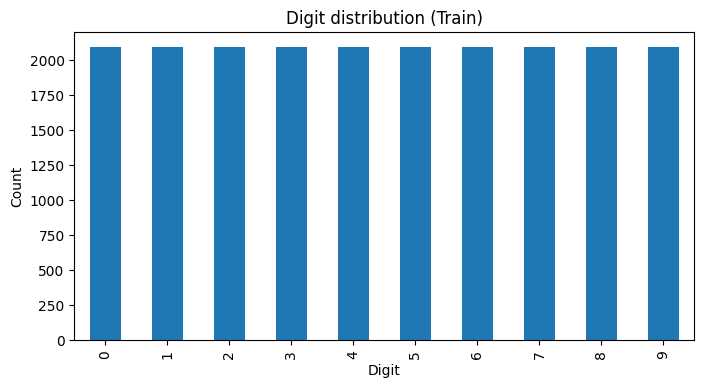

Train distribution plot saved.


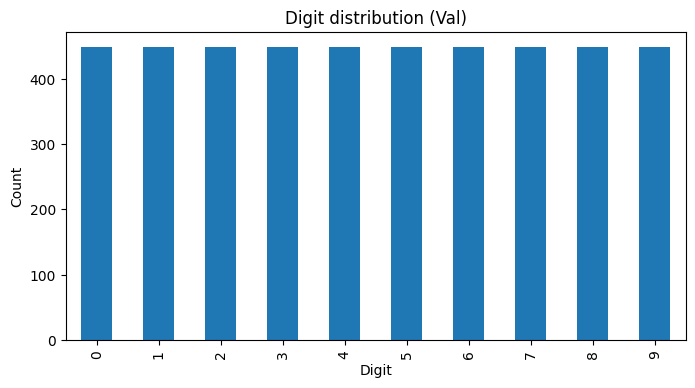

Val distribution plot saved.


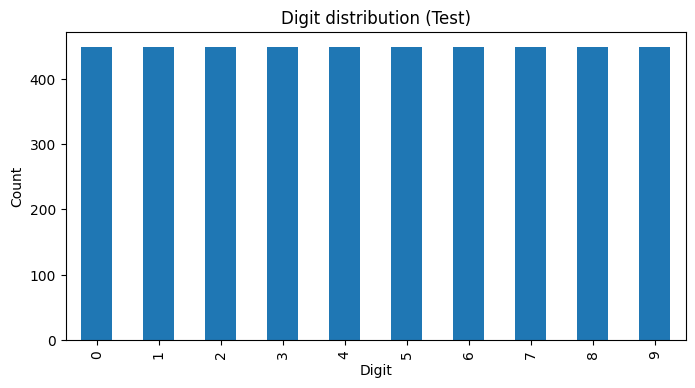

Test distribution plot saved.


In [8]:
# Dataset splitting by speakers (speaker-independent)
def split_dataset_by_speakers(df, test_size=0.3, val_size=0.5, random_seed=RANDOM_SEED):
    """
    Split metadata DF into train/val/test by speakers for independence.
    
    Args:
        df (pd.DataFrame): Metadata with 'speaker' column.
        test_size (float): Proportion for val+test.
        val_size (float): Split of temp into val/test.
        random_seed (int): For reproducibility.
    
    Returns:
        train_df, val_df, test_df (pd.DataFrame)
    """
    speakers = sorted(df['speaker'].unique())  # Sorted for consistency
    train_spk, temp_spk = train_test_split(speakers, test_size=test_size, random_state=random_seed)
    val_spk, test_spk = train_test_split(temp_spk, test_size=val_size, random_state=random_seed)
    
    print(f"Speakers: train={len(train_spk)}, val={len(val_spk)}, test={len(test_spk)}")
    
    def split_by_speakers(sub_df, spk_list):
        return sub_df[sub_df['speaker'].isin(spk_list)].reset_index(drop=True)
    
    train_df = split_by_speakers(df, train_spk)
    val_df = split_by_speakers(df, val_spk)
    test_df = split_by_speakers(df, test_spk)
    
    # Save splits for reproducibility
    train_df.to_csv(CACHE_DIR / "train_df.csv", index=False)
    val_df.to_csv(CACHE_DIR / "val_df.csv", index=False)
    test_df.to_csv(CACHE_DIR / "test_df.csv", index=False)
    print("Split DFs saved to cache.")
    
    return train_df, val_df, test_df

# Run splitting (or load from cache if needed; here we process)
train_df, val_df, test_df = split_dataset_by_speakers(meta_df)

# Print stats
for name, d in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
    print(f"{name}: {len(d)} samples, {d['speaker'].nunique()} speakers")

# Plot and save digit distributions
for name, d in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
    plt.figure(figsize=(8, 4))
    d['digit'].value_counts().sort_index().plot.bar()
    plt.title(f"Digit distribution ({name})")
    plt.xlabel("Digit")
    plt.ylabel("Count")
    plt.savefig(WORK_DIR / f"digit_dist_{name.lower()}.png")
    plt.show()
    plt.close()
    print(f"{name} distribution plot saved.")

### <p align="justify"><font size="6" color="#d62b5b">Step 4: Model Selection and Training</font></p>
<p align="justify">

#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 8: Digit Recognition (main task)</b></font></p>

- 10-class classification problem (digits 0–9) using 2D Mel spectrograms.

In [ ]:
# Optional: Install torchsummary if not available (uncomment in Kaggle/local)
# !pip install torch-summary

# Model definition
import torch.nn as nn
import torch
try:
    from torchsummary import summary  # For model summary
except ImportError:
    summary = None  # Will skip if not installed

def init_weights(m):
    """Xavier (Glorot) uniform initialization for Conv2d and Linear layers."""
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

class CNN_Small(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(CNN_Small, self).__init__()
        self.num_classes = num_classes
        
        # Explicit input shape (channels, height, width)
        channels, height, width = 1, N_MELS, (TARGET_LEN // HOP_LENGTH) + 1
        
        # Conv blocks
        self.features = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )
        
        # Compute flattened size with dummy input (add batch dim!)
        with torch.no_grad():
            dummy = torch.zeros(1, channels, height, width)  # (B, C, H, W) = (1, 1, 128, 32)
            flattened = self.features(dummy).view(1, -1).size(1)  # 64 * 32 * 8 = 16384
        
        self.classifier = nn.Sequential(
            nn.Linear(flattened, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
        # Apply initialization
        self.apply(init_weights)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Instantiate and move to device
model = CNN_Small(num_classes=NUM_CLASSES).to(device)
print(model)

# Model summary
if summary is not None:
    try:
        summary(model, input_size=(1, N_MELS, (TARGET_LEN // HOP_LENGTH) + 1))
    except Exception as e:
        print(f"Summary failed: {e}")
else:
    print("torchsummary not available; skipping summary.")
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable params: {total_params:,}")

CNN_Small(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16384, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 128, 32]   

⚙️ Training Setup

In [10]:
# Helper: Load cached .npy features with progress and error handling
def load_features(df, desc="Loading features"):
    feats = []
    for path in tqdm(df['feature_path'], desc=desc):
        try:
            feat = np.load(path)  # (N_MELS, time_frames) e.g., (128, 32)
            assert feat.shape == (N_MELS, (TARGET_LEN // HOP_LENGTH) + 1), f"Shape mismatch: {feat.shape} for {path}"
            feats.append(feat)
        except Exception as e:
            logging.warning(f"Failed loading {path}: {e}")
            continue
    if not feats:
        raise ValueError("No features loaded.")
    return np.stack(feats)  # (samples, height, width)

# Load features
X_train = load_features(train_df, desc="Loading train features")
Y_train = train_df['digit'].to_numpy()
X_val = load_features(val_df, desc="Loading val features")
Y_val = val_df['digit'].to_numpy()
X_test = load_features(test_df, desc="Loading test features")  # Load test too for later eval
Y_test = test_df['digit'].to_numpy()

# Normalize: Compute mean/std from train (channel-wise for spectrograms)
mean = X_train.mean()
std = X_train.std()
X_train = (X_train - mean) / (std + 1e-6)
X_val = (X_val - mean) / (std + 1e-6)
X_test = (X_test - mean) / (std + 1e-6)
print(f"Normalization: mean={mean:.4f}, std={std:.4f}")

# Convert to PyTorch tensors
def to_tensors(X, Y):
    X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # (samples, 1, height, width)
    Y_tensor = torch.tensor(Y, dtype=torch.long)
    return X_tensor, Y_tensor

X_train_tensor, Y_train_tensor = to_tensors(X_train, Y_train)
X_val_tensor, Y_val_tensor = to_tensors(X_val, Y_val)
X_test_tensor, Y_test_tensor = to_tensors(X_test, Y_test)

# Save tensors for reproducibility/local use
torch.save({'X': X_train_tensor, 'Y': Y_train_tensor}, CACHE_DIR / "train_tensors.pt")
torch.save({'X': X_val_tensor, 'Y': Y_val_tensor}, CACHE_DIR / "val_tensors.pt")
torch.save({'X': X_test_tensor, 'Y': Y_test_tensor}, CACHE_DIR / "test_tensors.pt")
print("Tensors saved to cache.")

# DataLoaders with reproducible shuffling
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(RANDOM_SEED)

train_loader = DataLoader(
    TensorDataset(X_train_tensor, Y_train_tensor),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,  # Speed up; set 0 for CPU/repro issues
    worker_init_fn=seed_worker,
    generator=g
)
val_loader = DataLoader(
    TensorDataset(X_val_tensor, Y_val_tensor),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)
test_loader = DataLoader(  # For later eval
    TensorDataset(X_test_tensor, Y_test_tensor),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

Loading test features: 100%|██████████| 4500/4500 [00:00<00:00, 9975.13it/s] 


Normalization: mean=-60.8624, std=19.5190
Tensors saved to cache.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


🏋️‍♂️ Training Loop

Training epochs:   7%|▋         | 1/15 [00:04<01:03,  4.52s/it]

Epoch [1/15] - Train Loss: 0.7359, Val Loss: 0.1573, Val Acc: 94.78%
Best model saved (Val Acc: 94.78%)


Training epochs:  13%|█▎        | 2/15 [00:08<00:53,  4.10s/it]

Epoch [2/15] - Train Loss: 0.1475, Val Loss: 0.1306, Val Acc: 95.89%
Best model saved (Val Acc: 95.89%)


Training epochs:  20%|██        | 3/15 [00:12<00:47,  3.96s/it]

Epoch [3/15] - Train Loss: 0.1097, Val Loss: 0.0814, Val Acc: 97.49%
Best model saved (Val Acc: 97.49%)


Training epochs:  27%|██▋       | 4/15 [00:15<00:42,  3.88s/it]

Epoch [4/15] - Train Loss: 0.0913, Val Loss: 0.0854, Val Acc: 97.58%
Best model saved (Val Acc: 97.58%)


Training epochs:  33%|███▎      | 5/15 [00:19<00:38,  3.83s/it]

Epoch [5/15] - Train Loss: 0.0761, Val Loss: 0.0974, Val Acc: 97.27%


Training epochs:  40%|████      | 6/15 [00:23<00:34,  3.82s/it]

Epoch [6/15] - Train Loss: 0.0699, Val Loss: 0.0847, Val Acc: 98.02%
Best model saved (Val Acc: 98.02%)


Training epochs:  47%|████▋     | 7/15 [00:27<00:30,  3.80s/it]

Epoch [7/15] - Train Loss: 0.0612, Val Loss: 0.0916, Val Acc: 97.76%


Training epochs:  53%|█████▎    | 8/15 [00:30<00:26,  3.80s/it]

Epoch [8/15] - Train Loss: 0.0428, Val Loss: 0.0654, Val Acc: 98.58%
Best model saved (Val Acc: 98.58%)


Training epochs:  60%|██████    | 9/15 [00:34<00:22,  3.79s/it]

Epoch [9/15] - Train Loss: 0.0424, Val Loss: 0.0734, Val Acc: 97.96%


Training epochs:  67%|██████▋   | 10/15 [00:38<00:19,  3.82s/it]

Epoch [10/15] - Train Loss: 0.0313, Val Loss: 0.0532, Val Acc: 98.67%
Best model saved (Val Acc: 98.67%)


Training epochs:  73%|███████▎  | 11/15 [00:42<00:15,  3.80s/it]

Epoch [11/15] - Train Loss: 0.0335, Val Loss: 0.0709, Val Acc: 98.44%


Training epochs:  80%|████████  | 12/15 [00:46<00:11,  3.79s/it]

Epoch [12/15] - Train Loss: 0.0293, Val Loss: 0.1502, Val Acc: 97.60%


Training epochs:  87%|████████▋ | 13/15 [00:49<00:07,  3.78s/it]

Epoch [13/15] - Train Loss: 0.0280, Val Loss: 0.1001, Val Acc: 98.31%


Training epochs:  93%|█████████▎| 14/15 [00:53<00:03,  3.77s/it]

Epoch [14/15] - Train Loss: 0.0258, Val Loss: 0.0878, Val Acc: 98.33%


Training epochs:  93%|█████████▎| 14/15 [00:57<00:04,  4.10s/it]

Epoch [15/15] - Train Loss: 0.0210, Val Loss: 0.0707, Val Acc: 98.51%
Early stopping at epoch 15
✅ Training complete. Log saved to /kaggle/working/cache/training_log.csv


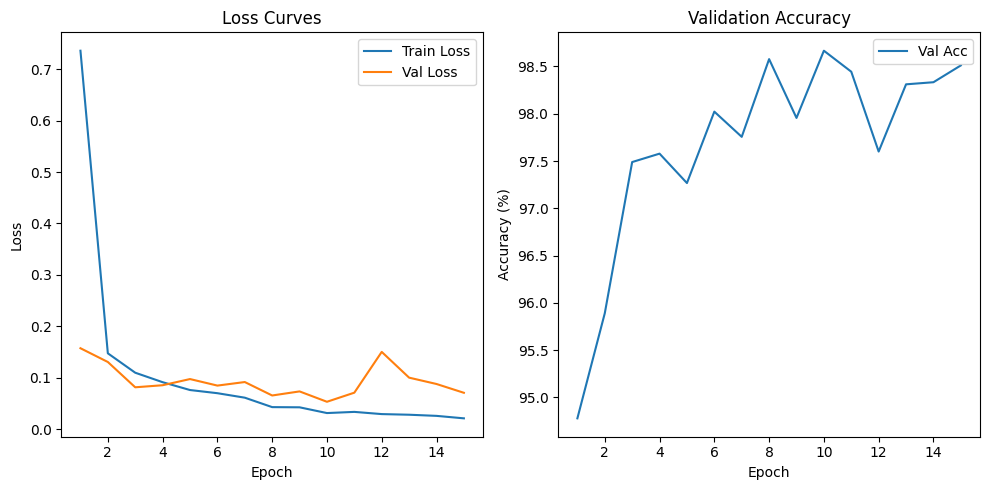

Metrics plot saved to working dir.


In [ ]:
# Training loop with improvements
MODEL_PATH = WORK_DIR / "best_model.pth"
LOG_PATH = CACHE_DIR / "training_log.csv"

# Early stopping params
patience = 5
best_val_acc = 0.0
epochs_no_improve = 0
early_stop = False

# Setup logging CSV
with open(LOG_PATH, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Epoch", "Train Loss", "Val Loss", "Val Acc"])

train_losses, val_losses, val_accuracies = [], [], []

for epoch in tqdm(range(NUM_EPOCHS), desc="Training epochs"):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Stability
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    
    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    val_loss_val = val_loss / len(val_loader.dataset)
    val_acc = 100 * correct / total
    
    # Scheduler step
    scheduler.step(val_loss_val)
    
    # Logging
    train_losses.append(train_loss)
    val_losses.append(val_loss_val)
    val_accuracies.append(val_acc)
    with open(LOG_PATH, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch+1, f"{train_loss:.4f}", f"{val_loss_val:.4f}", f"{val_acc:.2f}"])
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss_val:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Checkpoint best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"Best model saved (Val Acc: {val_acc:.2f}%)")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            early_stop = True
            break

print("✅ Training complete. Log saved to", LOG_PATH)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy')
plt.tight_layout()
plt.savefig(WORK_DIR / "training_metrics.png")
plt.show()
plt.close()
print("Metrics plot saved to working dir.")

🧪 Evaluation & Test

✅ Test Loss: 0.0292, Test Accuracy: 99.24%


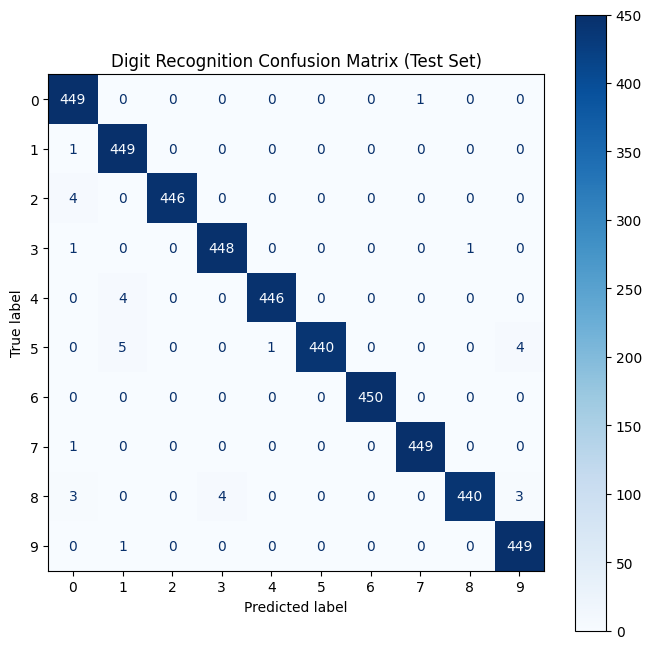

CM plot saved to working dir.

Classification Report:
              precision    recall  f1-score   support

           0     0.9782    0.9978    0.9879       450
           1     0.9782    0.9978    0.9879       450
           2     1.0000    0.9911    0.9955       450
           3     0.9912    0.9956    0.9933       450
           4     0.9978    0.9911    0.9944       450
           5     1.0000    0.9778    0.9888       450
           6     1.0000    1.0000    1.0000       450
           7     0.9978    0.9978    0.9978       450
           8     0.9977    0.9778    0.9877       450
           9     0.9846    0.9978    0.9912       450

    accuracy                         0.9924      4500
   macro avg     0.9925    0.9924    0.9924      4500
weighted avg     0.9925    0.9924    0.9924      4500

Report saved to working dir.


In [12]:
# Evaluation on test set
# Load best model (ensure using the trained/best weights)
model.load_state_dict(torch.load(MODEL_PATH))
model.to(device)
model.eval()

# Accumulate predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    test_loss = 0.0
    correct = 0
    total = 0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

test_loss /= len(test_loader.dataset)
acc = 100 * correct / total
print(f"✅ Test Loss: {test_loss:.4f}, Test Accuracy: {acc:.2f}%")

# Log to CSV
with open(LOG_PATH, 'a', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Test", f"{test_loss:.4f}", "-", f"{acc:.2f}"])

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Blues", colorbar=True)
plt.title("Digit Recognition Confusion Matrix (Test Set)")
plt.savefig(WORK_DIR / "confusion_matrix.png")
plt.show()
plt.close()
print("CM plot saved to working dir.")

# Classification Report
report = classification_report(all_labels, all_preds, digits=4)
print("\nClassification Report:")
print(report)
with open(WORK_DIR / "classification_report.txt", 'w') as f:
    f.write(report)
print("Report saved to working dir.")